# Matrices as Images

In our first reading on matrices, we said that one important reason data scientists have to know how to work with matrices is that, from the perspective of a computer, images are basically just matrices. 

Uh... what?

Most of us are accustomed to thinking about digital images as a grid of pixels, where each pixel is a square that contains a single color. But as we have learned in our previous classes, everything in a computer is a number, including colors. So instead of thinking of an image as a grid of little boxes filled with colors, computers see an image as a grid of numbers where each number represents a color. And a grid of numbers is nothing but a matrix!

To illustrate, let's load a simple greyscale `.png` photo of some jellyfish from the Monterey Bay Aquarium in California and display it using the `imshow` function from the `matplotlib` `pyplot` library:

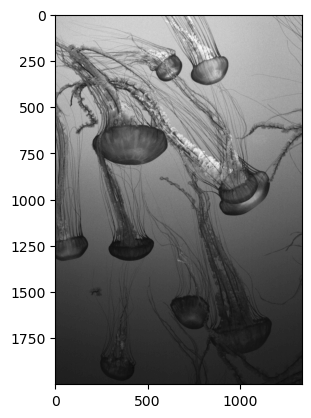

In [26]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np

# load image as pixel array
jellyfish = image.imread("images/jellyfish.png")
plt.imshow(jellyfish, cmap="gray")

(A small aside: The photo that we *actually* wanted to use for this reading was the logo of the [Monty Python](https://en.wikipedia.org/wiki/Monty_Python) comedy group, but we couldn't find a good photo that wasn't copyrighted. Why? Because despite what you might naturally assume given the prevalence of snake images on Python websites, [the Python programming language is actually named after the Monty Python comedy group, not the snake!](https://en.wikipedia.org/wiki/Python_(programming_language)#Design_philosophy_and_features) But we didn't want to get sued, so you will have to settle for a photo of jellyfish I took on vacation. :) )

OK, so we can display this image, but what does that have to do with numpy? The answer is that this entire image is being represented by a 2000 x 1334 numpy matrix where each entry of the matrix contains a single value between 0 and 1 corresponding to how dark (values close to 0) or light (values close to 1) the corresponding pixel should be drawn:

In [27]:
type(jellyfish)

numpy.ndarray

In [28]:
jellyfish.shape

(2000, 1334)

In [29]:
jellyfish

array([[0.7474784 , 0.7514458 , 0.75539786, ..., 0.7237659 , 0.7198138 ,
        0.7237659 ],
       [0.7474784 , 0.771252  , 0.7593652 , ..., 0.70405126, 0.727718  ,
        0.7435111 ],
       [0.727718  , 0.73562217, 0.7514458 , ..., 0.70405126, 0.7198138 ,
        0.739559  ],
       ...,
       [0.14572366, 0.14229038, 0.1388571 , ..., 0.10151827, 0.10823224,
        0.11158923],
       [0.13543908, 0.13543908, 0.1388571 , ..., 0.11158923, 0.11158923,
        0.11496147],
       [0.1388571 , 0.14229038, 0.1388571 , ..., 0.11496147, 0.10823224,
        0.11158923]], dtype=float32)

## Image Manipulation

Because this is just a numpy array, we can manipulate it with basic numpy tools! For example, to make everything darker, we can just make all the numbers smaller by multiplying by 0.25:

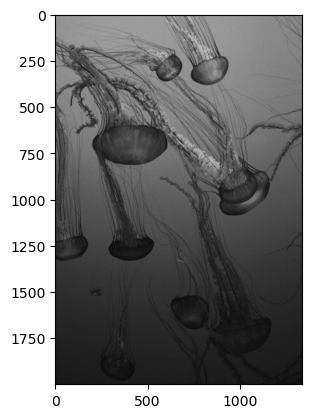

In [34]:
darker = jellyfish * 0.75
plt.imshow(darker, cmap="gray", vmin=0, vmax=1)

Note that we had to add the keyword arguments `vmin=0` and `vmax=1` to make this work;by default, `imshow` treats the maximum value in matrix as perfect white and the minimum value as perfect black, so without telling it that we want a value of 1 to correspond to perfect white, it would have just treated the new maximum value and the array `darker` (`0.75`) as perfect white, and the way the image looked would not have changed.

We can also do more complicated manipulations. Suppose we wanted to increase the contrast of the image. How might we accomplish that?

Well, if we only wanted values that were perfectly black or white (i.e. we wanted a two-tone image), we convert our greyscale image to a purely black and white image by converting values below a threshold to `False` (and thus, effectively, to zero) and values above a threshold to `True` (and thus, effectively, to 1). Admittedly this doesn't generate the most interesting image, but it does provide a simple illustration of how we can manipulate images by playing with the underlying numerical data.

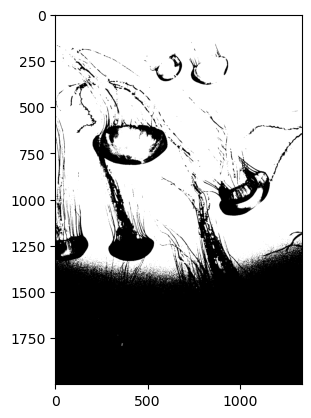

In [44]:
# Convert Greyscale to Two-Tone
two_tone = jellyfish > 0.3
plt.imshow(two_tone, cmap="gray")

## Adjusting Contrast

We can also up the contrast without going all the way to a two-tone image, although we have to be a little more clever to do so. Can you think of how we might accomplish this? 

Stop before reading ahead for a minute and trying and think of a way of moving all the values in this matrix away from 0.5 towards 0 and 1.

Seriously, think about it!

Fundamentally, we increase contrast by moving values away from middle tones (greys) and towards the extremes of 0s (black) and 1 (white). So we need a function that's going to take the current values, and disproportionately move values that are in the middle towards the extremes. In mathematical terms, we need a nonlinear transformation! Don't worry if that doesn't mean anything to you, or if the next section feels a little abstract or out of your comfort zone—this is mostly here to illustrate how mathematical manipulations of matrices give rise to the types of settings adjustments that you see in tools like Adobe Photoshop.

In this case, let's use one of the most simple nonlinear transformations: the square root function. When we take the square root of a positive number between 0 and 1, the result will increase in size by a larger amount the closer the original number is to 0 (while values close to 1 barely change). For example, if we raise values to 0.5 (in other words, take the square root of values), 0.1 becomes 0.31, while 0.9 only becomes 0.95. Here is the square root function illustrated graphically:

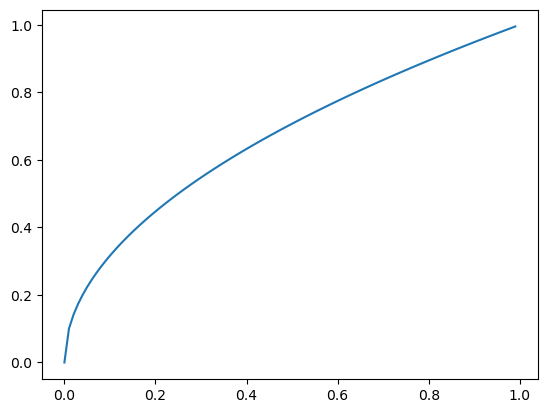

In [45]:
zero_to_one = np.arange(0, 1, 0.01)
plt.plot(zero_to_one, np.sqrt(zero_to_one))

So to create a function that moves values that are close to 0.5 more than values that are close to 0 or 1, we need to do a couple little tricks. First, we subtract 0.5 from all of the values and our matrix so that the grey pixels now have a value of 0, blacks have a value of -0.5, and whites have a value of 0.5. Then we double all the values so black is -1 and white is 1.

Now if we square the absolute values of all of our pixels (and make the pixels that had negative signs negative again), all the pixels that had values close to 0 will have moved significantly in the direction of -1 or 1, while values that were close to -1 or 1 will not have moved very much.

Then we just reverse our shift and scaling (divided by two so the values lie between -0.5 and 0.5, then add 0.5 so they're back being between 0 and 1), and we have our image with increased contrast!

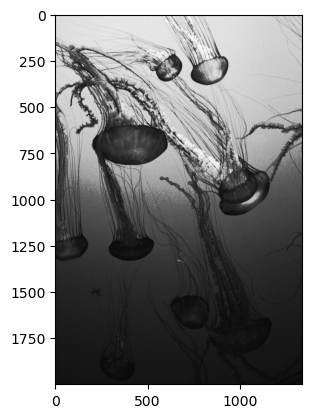

In [47]:
def change_contrast(image):
    # shift values so they lie between -1 and 1
    re_center_and_re_scale = (image - 0.5) * 2

    # take square root of absolute value
    # (the square root of the negative number is undefined)
    squared_values = np.abs(re_center_and_re_scale) ** 0.5

    # make the negative values negative again
    correctly_signed_and_squared = squared_values * np.sign(re_center_and_re_scale)

    # Shift back and rescale
    shifted_and_scaled_back = (correctly_signed_and_squared / 2) + 0.5
    return shifted_and_scaled_back


plt.imshow(change_contrast(jellyfish), cmap="gray", vmin=0, vmax=1)

Which we can compare to our original image:

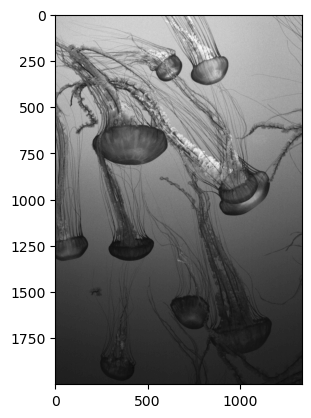

In [48]:
plt.imshow(jellyfish, cmap="gray")

### Generalizing Contrast Adjustment

In fact, we can even generalize this trick—taking the square root of a number is the same as raising it to the power 0.5, and it turns out that raising numbers that lie between 0 and 1 to any exponent that is less than one will do this same trick, just to different degrees. So we can just make the exponent being used a parameter to our function.

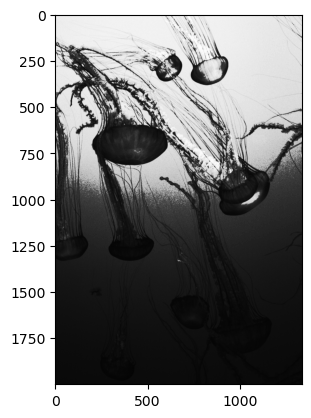

In [49]:
def change_contrast(image, exponent=0.5):
    # shift values so they lie between -1 and 1
    re_center_and_re_scale = (image - 0.5) * 2

    # take square root of absolute value
    # (the square root of the negative number is undefined)
    squared_values = np.abs(re_center_and_re_scale) ** exponent

    # make the negative values negative again
    correctly_signed_and_squared = squared_values * np.sign(re_center_and_re_scale)

    # Shift back and rescale
    shifted_and_scaled_back = (correctly_signed_and_squared / 2) + 0.5
    return shifted_and_scaled_back


plt.imshow(change_contrast(jellyfish, 0.25), cmap="gray", vmin=0, vmax=1)

And in fact we can now use this function to *reduce* the image contrast by passing an exponent that is greater than one, which will have the exact opposite effect!

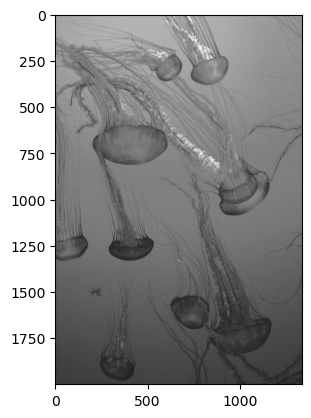

In [51]:
# decrease contrast with an exponent greater than one
plt.imshow(change_contrast(jellyfish, exponent=2), cmap="gray", vmin=0, vmax=1)

Voilà! Now you can stop paying Photoshop for a license and edit all your photos yourself! OK, we're probably not there yet, but this *is* precisely what programs like Photoshop are doing behind the scenes. 

## Color Images

As you've hopefully seen with this greyscale image, thinking of images as matrices is a very powerful perspective and one that underlies all digital image processing. 

But how does this work with color images? The answer depends a little on the color encoding that a photo format uses, but for most formats, the color of a pixel can actually be represented by 3 numbers per pixel corresponding to the relative contributions of the primary colors of red, green, and blue that, added together, make up the final image. This can also be represented with numpy arrays, but as doing so requires using three-dimensional arrays (which we haven't covered yet), we will defer discussion of color images for a little while. Don't worry though, will come back to them!
